In [1]:
library(naturalsort)
library(data.table)
library(data.tree)
library(Biostrings)
dataDir <- '../../Data/SimOut6/'

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: IRanges

Attaching package: ‘IRanges’

The follo

In [2]:
flst<-list.files(dataDir) # Get list of files from directory
flst <- naturalsort(flst) # Natural sort the files
ncls <- c()
rs <- c()
k<-1
for (i in 1:(length(flst)-1)) {
    load(paste0(dataDir,flst[i]))
    if (CellPop$totalCount==1) {
        ncls[[k]] <- CellPop$ncells[length(CellPop$ncells)]
    }
    else {
        ncls[[k]] <- sum(vapply(CellPop$Get('ncells'),tail,n=1L,FUN.VALUE = numeric(1)))
    }
    rs[[k]] <- CellPop$Get('r')
    rm('CellPop')
    k <- k+1
    
}

In [3]:
rs_var <- c()
ncells_var <- c()

for (i in 1:length(rs)) {
    
    if (length(rs[[i]])==1) {rs_var[i] <- 0}
    else {rs_var[i] <- var(rs[[i]])}
    ncells_var[i] <- var(ncls[[i]])

}

In [4]:
norml <- function(x) {
    x = (x-min(x))/(max(x)-min(x))
    return(x)}

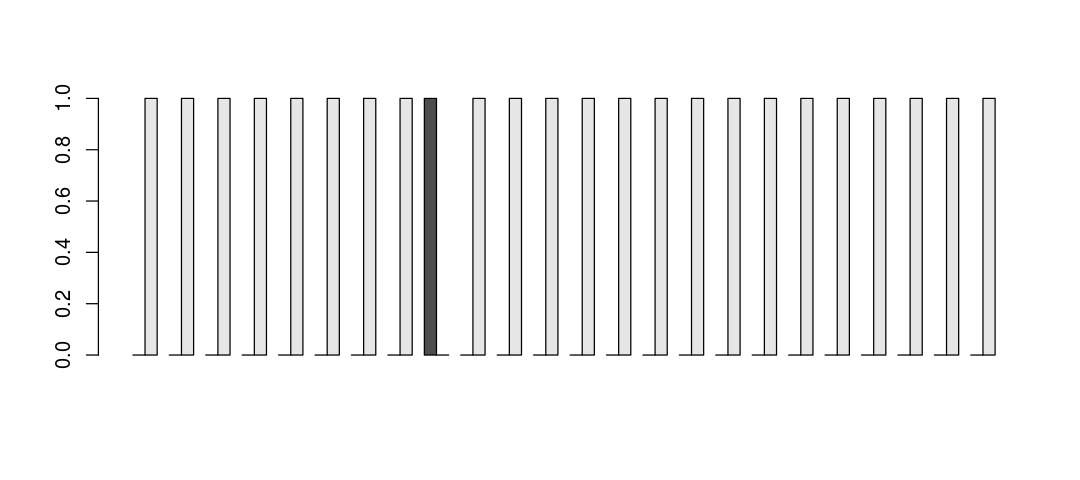

In [19]:
barplot(as.matrix(rbind(norml(rs_var),norml(ncls))),beside=TRUE)
options(repr.plot.width=9, repr.plot.height=4)

In [6]:
load('../../Data/SimOut6/8.rda')

In [7]:
print(CellPop,'r')

  levelName   r
1     1     1.0
2      ¦--2 0.2
3      ¦--3 1.0
4      °--4 1.0


In [8]:
traversal <- Traverse(CellPop, traversal = "post-order", filterFun = function(x) x$r != 1)

In [9]:
traversal[[1]]$tes

[[1]]
  A DNAStringSet instance of length 1
    width seq
[1]   443 GGGGGAGGAGCCAAGATGGCCGAATAGGAACAGC...TGCAAGGCGGCAACGAGGCTGGGGGAGGGGCGC

[[2]]
[1] "chr20"

[[3]]
[1] 299348

[[4]]
[1] "-"


In [10]:
# PURPOSE: Updates the gene annotation of the clone
#
# INPUT:
#   anno         (data frame) Annotation of genes (i.e. chromosome   start   end)
#   simout          (list of lists) gen_sim output
#   tes             (list of lists) Node tes
#
# OUTPUT: anno

update_anno <- function(anno,  tes) {
    
#     tmp = mapply(append, simout, tes, SIMPLIFY = FALSE)
    tmp=tes
    for (i in 1:length(tmp[[3]])) {
        # Shift the start loci of genes with start loci beyond the insertion by the width of the L1
        anno[anno$chrom==tmp[[2]][i] & anno$start>tmp[[3]][i],]$start <- anno[anno$chrom==tmp[[2]][i] & anno$start>tmp[[3]][i],]$start + width(tmp[[1]][i])  
        # Shift the end loci of genes with start loci beyond the insertion by the width of the L1
        anno[anno$chrom==tmp[[2]][i] & anno$start>tmp[[3]][i],]$end <- anno[anno$chrom==tmp[[2]][i] & anno$start>tmp[[3]][i],]$end + width(tmp[[1]][i])  
        # Shift the end locus of any gene with only end locus beyond the insertion by the width of the L1
        anno[anno$chrom==tmp[[2]][i] & anno$end>tmp[[3]][i] & anno$start<tmp[[3]][i],]$end <- anno[anno$chrom==tmp[[2]][i] & anno$end>tmp[[3]][i] & anno$start<tmp[[3]][i],]$end + width(tmp[[1]][i])        
    }
    return(anno) 
}

In [11]:
rank_clone <- function(r, anno, sites_chrm, sites_loci, gainp, lossp) {

    gene_hits=0; # set counter to zero
    tsg_hits=0;
    for (i in 1:length(unique(sites_chrm))) { # loop over chromosomes inserted into
        tmp=anno[anno$chrom==unique(sites_chrm)[i],] # reduce annotation table to entries for current chrom
        chrmann_ntsg=tmp[tmp$istsg==0,]
        chrmann_tsg =tmp[tmp$istsg==1,]
        tmp = sites_loci[sites_chrm==unique(sites_chrm)[i]] # reduce insertion loci to entries for current chrom
        tmp_hits = between(tmp,chrmann_ntsg$start,chrmann_ntsg$end) # create logical for insertions, whether into non-tsg-gene or not
        gene_hits=gene_hits+length(which(tmp_hits==TRUE)) # count the number of non-tsg-gene insertions
#         print(gene_hits)
        tmp_hits  = between(tmp,chrmann_tsg$start,chrmann_tsg$end) # same for tsg-gene insertions
        tsg_hits =tsg_hits+length(which(tmp_hits==TRUE))
    }

    if (gene_hits > 0 || tsg_hits > 0){
        r=r*(lossp^gene_hits)*(gainp^tsg_hits)
    }

    if (r < 0.25) { # If the division rate is below 0.25, the clone stops growing
        r<-0
    }

    return(r)
}


In [12]:
load('../../sim-develop/data/exann.rda')

In [13]:
head(exann)

chrom,start,end,istsg
chr1,11874,12227,0
chr1,12595,12721,0
chr1,13221,14409,0
chr1,30366,30503,0
chr1,69091,70008,0
chr1,182393,182746,0


In [14]:
k <- traversal[[1]]$tes

In [15]:
k

[[1]]
  A DNAStringSet instance of length 1
    width seq
[1]   443 GGGGGAGGAGCCAAGATGGCCGAATAGGAACAGC...TGCAAGGCGGCAACGAGGCTGGGGGAGGGGCGC

[[2]]
[1] "chr20"

[[3]]
[1] 299348

[[4]]
[1] "-"


In [16]:
tmpAnn <- update_anno(exann,k)

In [17]:
load('../../sim-develop/data/exann.rda')
for (node in traversal) {
    nodeTes <- node$tes
    tmpAnn <- update_anno(exann,nodeTes)
    
    
}

In [18]:
r <- rank_clone(1,tmpAnn,k[[2]],k[[3]],1.2,.8)
r

[1] 0.8